# Fitting data with `easyscience`

The `easyscience` library is designed to enable model-dependent analysis, using a pure Python interface, and give access to a range of optimization algorithms. 
It is possible to analyse any data for which there is a closed-form mathematical description (i.e., a mathematical model) with parameters to be refined. 

This short demonstration will show how `easyscience` can be used to analyse the toy problem of data following a quadratic relationship. 
We manufacture some quadratic data to work with below. 
````{margin}
```{note}
We set the random seed to ensure reproducibility in this example. 
```
````

In [1]:
import numpy as np

np.random.seed(123)

a_true = -0.9594
b_true = 7.294
c_true = 3.102

N = 25
x = np.linspace(0, 10, N)

yerr = 1 + 1 * np.random.rand(N)
y = a_true * x ** 2 + b_true * x + c_true
y += np.abs(y) * 0.1 * np.random.randn(N)

The data created above is shown as a standard error bar plot below.

import matplotlib.pyplot as plt

plt.errorbar(x, y, yerr, marker='.', ls='', color='k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The next step is to create an `easyscience` analysis model. 
In this example, this consists of three parameters called `a`, `b`, and `c`.
These parameters are created and initialised with the true values from above, they are all set with `fixed=False` as the parameters should be allowed to vary, to find the optimum solution -- the only one that maximises the likelihood. 

In [2]:
from easyscience.Objects.new_variable import Parameter

a = Parameter(name='a', value=a_true, fixed=False)
b = Parameter(name='b', value=b_true, fixed=False)
c = Parameter(name='c', value=c_true, fixed=False)

The mathematical model that is to be optimised is
```{math}
:label: quadratic
y = a x ^ 2 + b x + c.
```

To use `easyscience` to optimise this, a Python function that implements this mathematical model is needed. 

We can create a function that implements this mathematical model as shown below. 

In [3]:
def math_model(x: np.ndarray) -> np.ndarray:
    """
    Mathematical model for a quadratic. 
    
    :x: values to calculate the model over. 
    
    :return: model values.
    """
    return a.value * x ** 2 + b.value * x + c.value

The initial guess (from the true value) for the mathematical model, along with the experimental data, can then be plotted. 

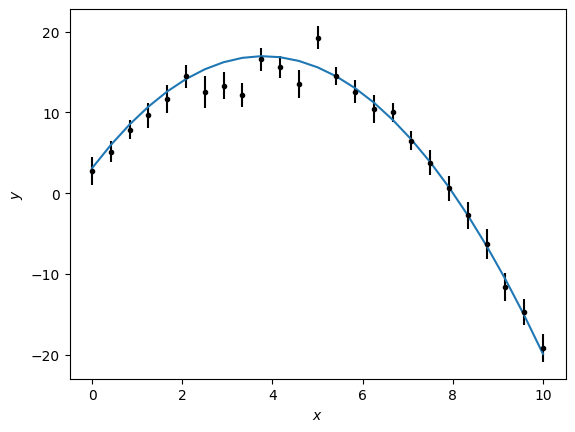

In [4]:
import matplotlib.pyplot as plt
plt.errorbar(x, y, yerr, marker='.', ls='', color='k')
plt.plot(x, math_model(x), '-')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

To optimise the parameters `a`, `b`, and `c`, a `BaseObj` must be created. 
This brings together all parameters to be optimised in a single object, which is then associated with the mathematical model in the `Fitter`. 
Note that parameters that are fixed should not be included.

In [5]:
from easyscience.Objects.ObjectClasses import BaseObj
from easyscience.fitting import Fitter

quad = BaseObj(name='quad', a=a, b=b, c=c)
f = Fitter(quad, math_model)


AttributeError: LMFit_leastsq

ValueError: Invalid minimizer name: bumps. The following minimizers are available: ['LMFit', 'LMFit_leastsq', 'LMFit_powell', 'LMFit_cobyla', 'Bumps', 'Bumps_simplex', 'Bumps_newton', 'Bumps_lm', 'DFO', 'DFO_leastsq']

In [ ]:
from easyscience.fitting.minimizers.factory import AvailableMinimizers

AvailableMinimizers.Bumps

<enum 'AvailableMinimizers'>

`easyscience` can then be used to determine the parameters of the quadratic model using {term}`maximum likelihood estimation` (MLE) .
`y` describes the position of the normal distributions for the data while the `weights` are the reciprocals of their widths.

In [ ]:
res = f.fit(x=x, y=y, weights=1/yerr)

With the MLE found, the parameters can be printed to screen to see the optimized values and estimated statistical uncertainties. 

In [ ]:
a, b, c

(<Parameter 'a': -0.9455 ± 0.0379, bounds=[-inf:inf]>,
 <Parameter 'b': 7.3277 ± 0.3800, bounds=[-inf:inf]>,
 <Parameter 'c': 2.0301 ± 0.8187, bounds=[-inf:inf]>)

Finally, the optimised model can be plotted with the experimental data, using the same visualisation as [previously](./prob_data.ipynb). 

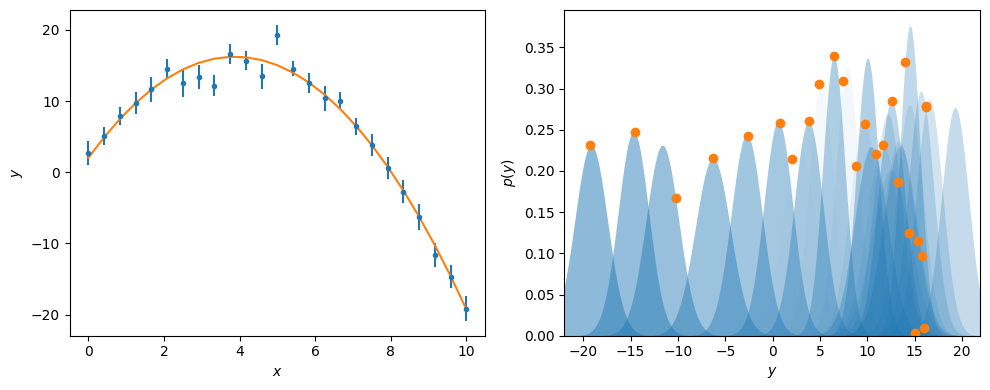

In [ ]:
from scipy.stats import norm

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].errorbar(x, y, yerr, marker='.', ls='', color='C0')
ax[0].plot(x, math_model(x), '-', color='C1')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')

y_range = np.arange(-22, 22, 0.1)
for i, yy in enumerate(y):
    ax[1].fill_between(y_range, norm(yy, yerr[i]).pdf(y_range), color='C0', alpha=0.02 * (i + 1), lw=0)
    ax[1].plot(math_model(x[i]), norm(yy, yerr[i]).pdf(math_model(x[i])), 'C1o')
ax[1].set_xlim(y_range.min(), y_range.max())
ax[1].set_ylim(0, None)
ax[1].set_xlabel('$y$')
ax[1].set_ylabel('$p(y)$')
plt.tight_layout()
plt.show()

This approach to use `easyscience` for the optimization of mathematical models can be applied to many different use cases, including in neutron scattering. 